# Loblaw Companies Ltd
### Grocery Web Scrape — Loblaws vs. NoFrills

Brian Morris - October 2022

### Table of Contents
1. [Introduction](#intro_id)
    - 1.1 [Import the libraries](#import_id)
    
    
2. [Web Scrape](#scrape_id)
    - 2.1 [Scrape Preparation](#prep_id)
    - 2.2 [Begin Scraping](#begin_id)
    
    
3. [Analysis](#analysis_id)
    - 3.1 [Load the data](#load_id)
    - 3.2 [Clean up dataframe](#clean_id)
    - 3.3 [Explore the NULL values](#null_id)
        - [Deal badge (sales)](#deal_id)
        - [Low stock, new product badge](#low_stock_id)
        - [Loyalty badge (PC points)](#loyalty_id)
    - 3.4 [Brand Counts](#brand_id)
    - 3.5 [Product Counts](#product_id)
    - 3.6 [Product Distribution by Category](#dist_id)
    - 3.7 [Matching ProductSKU in both stores](#match_id)
    - 3.8 [Product Prices](#prices_id)
    
    
4. [Targeted Insights](#target_id)


5. [Conclusion and Next Steps](#conclusion_id)


<a id='intro_id'></a>
## 1. Introduction

The goal of this notebook is to demonstrate the power of web scraping using open source tools available to everyone. As well as analyzing the grocery products of two popular stores, Loblaws and NoFrills.

Throughout this notebook, you will see how to scrape both grocery websites and different ways to compare the stores using data visualization techniques. We also target a specific case example by using the same shopping list at both stores and tracking its cost over the course of a week.

This scrape took place before, during, and after the Canadian Thanksgiving weekend. As such, it will be an example of grocery product inventory around a holiday weekend.

<a id='import_id'></a>
### 1.1 Import the libraries

In [1]:
# import web scraping tools

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
from datetime import datetime
import json
import time
import random
import re
import pandas as pd
import numpy as np

# import analysis tools

import plotly.offline as py # plotly for interactive and presentation graphs
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

py.init_notebook_mode(connected=True)
plt.style.use('seaborn') # use the seaborn style for matplotlib graphs

<a id='scrape_id'></a>
## 2. Web Scrape

The two grocery websites targeted in this webscrape are:
- Loblaws.ca
- Nofrills.ca

Both of these websites have 12 matching categories of groceries that I am interested in scraping, analysing, and comparing:
- Fruits & Vegetables
- Dairy & Eggs
- Pantry
- Meat
- Fish & Seafood
- Snacks, Chips, & Candy
- Drinks
- Frozen
- Natural Foods
- Deli
- Bakery
- Prepared Meals

<a id='prep_id'></a>
### 2.1 Scraping Preparation

In [3]:
# Get today's date and set into a variable for use later in the scrape
scrape_date = datetime.today().strftime('%Y-%m-%d')
scrape_date

'2022-10-12'

In [4]:
# Set-up the URLs for each of the 12 categories that I want to scrape:
url_list =[
 'https://www.loblaws.ca/food/fruits-vegetables/c/28000?navid=flyout-L2-see-all-Fruits-and-Vegetables',
 'https://www.nofrills.ca/food/fruits-vegetables/c/28000?navid=flyout-L2-see-all-Fruits-and-Vegetables',
 'https://www.loblaws.ca/food/dairy-eggs/c/28003?navid=flyout-L2-see-all-Dairy-and-Eggs',
 'https://www.nofrills.ca/food/dairy-eggs/c/28003?navid=flyout-L2-see-all-Dairy-and-Eggs',    
 'https://www.loblaws.ca/food/pantry/c/28006?navid=flyout-L2-see-all-Pantry',
 'https://www.nofrills.ca/food/pantry/c/28006?navid=flyout-L2-see-all-Pantry',
 'https://www.loblaws.ca/food/meat/c/27998?navid=flyout-L2-see-all-Meat',
 'https://www.nofrills.ca/food/meat/c/27998?navid=flyout-L2-see-all-Meat',   
 'https://www.loblaws.ca/food/fish-seafood/c/27999?navid=flyout-L2-see-all-Fish-and-Seafood',
 'https://www.nofrills.ca/food/fish-seafood/c/27999?navid=flyout-L2-see-all-Fish-and-Seafood',
 'https://www.loblaws.ca/food/snacks-chips-candy/c/57025?navid=flyout-L2-see-all-Snacks-Chips-and-Candy',
 'https://www.nofrills.ca/food/snacks-chips-candy/c/57025?navid=flyout-L2-see-all-Snacks-Chips-and-Candy',
 'https://www.loblaws.ca/food/drinks/c/28004?navid=flyout-L2-see-all-Drinks',
 'https://www.nofrills.ca/food/drinks/c/28004?navid=flyout-L2-see-all-Drinks',    
 'https://www.loblaws.ca/food/frozen/c/28005?navid=flyout-L2-see-all-Frozen',
 'https://www.nofrills.ca/food/frozen/c/28005?navid=flyout-L2-see-all-Frozen',
 'https://www.loblaws.ca/food/pantry/natural-foods-/c/28189?navid=flyout-L2-see-all-Natural-Foods-',
 'https://www.nofrills.ca/food/pantry/natural-foods-/c/28189?navid=flyout-L2-see-all-Natural-Foods-',
 'https://www.loblaws.ca/food/deli/c/28001?navid=flyout-L2-see-all-Deli',
 'https://www.nofrills.ca/food/deli/c/28001?navid=flyout-L2-see-all-Deli',
 'https://www.loblaws.ca/food/bakery/c/28002?navid=flyout-L2-see-all-Bakery',
 'https://www.nofrills.ca/food/bakery/c/28002?navid=flyout-L2-see-all-Bakery',
 'https://www.loblaws.ca/food/prepared-meals/c/27996?navid=flyout-L2-see-all-Prepared-Meals',
 'https://www.nofrills.ca/food/prepared-meals/c/27996?navid=flyout-L2-see-all-Prepared-Meals'
]

In [5]:
# Run chrome
driver = webdriver.Chrome('C:\webdrivers\chromedriver.exe')

C:\Users\brand\AppData\Local\Temp/ipykernel_14476/3950893553.py:2: DeprecationWarning:

executable_path has been deprecated, please pass in a Service object



In [6]:
# maximize chrome window
driver.maximize_window()

<a id='begin_id'></a>
### 2.2 Begin Scraping
The cell below will begin scraping 24 websites (12 grocery categories from each website). Take every product dictionary it finds and append it to a daily DataFrame. Then save the DataFrame on disc as a backup for future analysis.

**Estimated scrape time:** 2 hours

In [7]:
# initalize a master list which will contain each category of products
master_list = [] 

# Main scraping loop
for url in url_list:
    
    driver.get(url) # navigate to the website for each category
    
    time.sleep(10) # wait for the page to fully load

    # capture the store name from the URL
    store = re.findall('https:\/\/www.(\w+).ca', url)
    
    # capture the grocery category from the URL
    category = re.findall('navid=flyout-L2-see-all-(\w+-\w+-\w+-\w+|\w+-\w+-\w+|\w+-\w+|\w+)-?', url)

    # the Pantry page is a special case, it loads over 4000 products by itself, requires greater time to load, otherwise a memory error occurs
    if (category[0] == 'Pantry'):
        # Loop as long as selenium can find the Load More Results button
        driver.execute_script('window.scrollTo(0, document.body.scrollHeight);') # Scroll to the bottom of the page to find the Load More button

        try:
            while driver.find_element(By.CLASS_NAME, 'primary-button--load-more-button'): # continue scrolling and clicking load more until the button does not exist
                driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
                driver.find_element(By.CLASS_NAME, 'primary-button--load-more-button').click()
                time.sleep(random.randint(24,26)) # increase the delay between loading more Pantry products
        except:
            print(f'Finished loading products for {store} {category}')
    else:
        # Loop as long as selenium can find the Load More Results button
        driver.execute_script('window.scrollTo(0, document.body.scrollHeight);') # Scroll to the bottom of the page to find the button

        try:
            while driver.find_element(By.CLASS_NAME, 'primary-button--load-more-button'): # continue scrolling and clicking load more until the button does not exist
                driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
                driver.find_element(By.CLASS_NAME, 'primary-button--load-more-button').click()
                time.sleep(random.randint(8,11)) # shorter delay between loading more products for all other categories
        except:
            print(f'Finished loading products for {store} {category}')
        
    # Soup a copy of the page source
    page_source_soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Find all products on the page
    product_list = page_source_soup.find_all('div', class_='product-tracking')

    # Extract each product's tracking information from the embedded attribute and slice off the square brackets
    product_list_details = [product['data-track-products-array'][1:-1] for product in product_list]

    # Convert each list item from str to a dictionary
    product_dict = [json.loads(product) for product in product_list_details]

    # Add company, category, and scrape_date key value to each product in the dict
    for i in range(len(product_dict)):
        product_dict[i]['category'] = category[0] # Adds the product category value to each product based on its product category
        product_dict[i]['store'] = store[0] # Add the store
        product_dict[i]['scrape_date'] = scrape_date # Add the scraped date

    master_list.append(product_dict)

# create a list for holding all individual products
product_list = []

# append every product into the product list
for category in master_list:
    for product in category:
        product_list.append(product)
        
# Create dataframe from all products scraped
daily_df = pd.DataFrame(product_list)

# save data frame as a csv for backup
daily_df.to_csv(f'data/Loblaws-NoFrills/{scrape_date}/{scrape_date}-daily-df.csv')

Finished loading products for ['loblaws'] ['Fruits-and-Vegetables']
Finished loading products for ['nofrills'] ['Fruits-and-Vegetables']
Finished loading products for ['loblaws'] ['Dairy-and-Eggs']
Finished loading products for ['nofrills'] ['Dairy-and-Eggs']
Finished loading products for ['loblaws'] ['Pantry']
Finished loading products for ['nofrills'] ['Pantry']
Finished loading products for ['loblaws'] ['Meat']
Finished loading products for ['nofrills'] ['Meat']
Finished loading products for ['loblaws'] ['Fish-and-Seafood']
Finished loading products for ['nofrills'] ['Fish-and-Seafood']
Finished loading products for ['loblaws'] ['Snacks-Chips-and-Candy']
Finished loading products for ['nofrills'] ['Snacks-Chips-and-Candy']
Finished loading products for ['loblaws'] ['Drinks']
Finished loading products for ['nofrills'] ['Drinks']
Finished loading products for ['loblaws'] ['Frozen']
Finished loading products for ['nofrills'] ['Frozen']
Finished loading products for ['loblaws'] ['Natura

<a id='analysis_id'></a>
## 3. Analysis
<a id='load_id'></a>
### 3.1 Load the data

In [8]:
# Populate the date list for scrape dates to be loaded to a master dataframe
date_lst = ['2022-10-5', 
            '2022-10-6', 
            '2022-10-7', 
            '2022-10-8', 
            '2022-10-9', 
            '2022-10-10',
            '2022-10-11',
            '2022-10-12']
daily_df_lst = []

for date in date_lst:
    df = pd.read_csv(f'data/Loblaws-NoFrills/{date}/{date}-daily-df.csv', index_col=0, parse_dates=['scrape_date'])
    df.reset_index(drop=True, inplace=True) # drop the loaded index column
    daily_df_lst.append(df)
    
df = pd.concat(daily_df_lst) # create master dataframe out of the daily dataframe list

<a id='clean_id'></a>
### 3.2 Clean up dataframe

In [9]:
# Drop the columns that contain no useful data
df.drop(['productCatalog',
         'productVendor',
         'productQuantity',
         'productPosition',
         'productOrderId',
         'productVariant',
         'subProduct',
         'productRating'], axis=1, inplace=True)

# Drop any duplicates
df.drop_duplicates(inplace=True)

In [12]:
# Check columns that need to have their data type changed
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155054 entries, 0 to 23816
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   productSKU    155054 non-null  object        
 1   productName   155054 non-null  object        
 2   productBrand  144762 non-null  object        
 3   productPrice  155054 non-null  float64       
 4   dealBadge     44735 non-null   object        
 5   loyaltyBadge  155054 non-null  bool          
 6   textBadge     15229 non-null   object        
 7   category      155054 non-null  object        
 8   store         155054 non-null  object        
 9   scrape_date   155054 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(1), object(7)
memory usage: 12.0+ MB


In [13]:
df.head(10)

,productSKU,productName,productBrand,productPrice,dealBadge,loyaltyBadge,textBadge,category,store,scrape_date
0,20049778001_EA,Strawberries 1LB,NaN,4.99,NaN,False,low-stock,Fruits-and-Vegetables,loblaws,2022-10-05
1,20135377001_EA,Cauliflower,NaN,2.99,sale,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-05
2,21367888001_EA,Grape Tomatoes,Farmer's Market,3.99,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-05
3,20167017001_EA,Cantaloupe,NaN,5.99,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-05
4,20426141001_KG,Tomato Beefsteak Red,NaN,1.47,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-05
5,20425893001_KG,Sweet Green Peppers,NaN,1.85,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-05
6,20143381001_KG,Roma Tomatoes,NaN,0.53,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-05
7,20026161001_KG,Broccoli Crowns,NaN,2.50,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-05
8,20159199001_KG,Red Seedless Grapes,NaN,6.52,sale,False,low-stock,Fruits-and-Vegetables,loblaws,2022-10-05
9,20127708001_KG,Sweet Potato,NaN,2.49,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-05


In [14]:
df.tail(10)

,productSKU,productName,productBrand,productPrice,dealBadge,loyaltyBadge,textBadge,category,store,scrape_date
23804,21378031_EA,Avocado Ranch Chopped Salad Kit,President's Choice,4.99,NaN,False,low-stock,Prepared-Meals,nofrills,2022-10-12
23805,20093406_EA,"Pasta Sauce, Classic Alfredo",Olivieri,4.99,NaN,False,NaN,Prepared-Meals,nofrills,2022-10-12
23808,21021520_EA,Skillet Gnocchi,Olivieri,5.79,sale,False,NaN,Prepared-Meals,nofrills,2022-10-12
23810,20132121_EA,Basil & Cheese Pesto,Olivieri,4.99,NaN,False,NaN,Prepared-Meals,nofrills,2022-10-12
23811,21334074_EA,Sweet Kale Salad Kit,President's Choice,6.99,NaN,False,NaN,Prepared-Meals,nofrills,2022-10-12
23812,21414456_EA,Bourbon Bacon,Taylor Farms,4.99,NaN,False,NaN,Prepared-Meals,nofrills,2022-10-12
23813,20084505_EA,Potato & Egg Salad,Ziggy's,3.99,NaN,False,NaN,Prepared-Meals,nofrills,2022-10-12
23814,21401761_EA,Quiche Florentine,Farmer's Market,6.00,sale,False,NaN,Prepared-Meals,nofrills,2022-10-12
23815,21378594_EA,Crispy Chicken Spring Rolls,Sum-m,4.69,NaN,False,NaN,Prepared-Meals,nofrills,2022-10-12
23816,21306210_EA,Cheese & Bacon Tortellini Fresh Pasta,Ziggy's,4.29,NaN,False,NaN,Prepared-Meals,nofrills,2022-10-12


In [16]:
# create a dataframe of products from the latest date scraped
latest_df = df[df['scrape_date'] == date_lst[-1]].copy()
latest_df

,productSKU,productName,productBrand,productPrice,dealBadge,loyaltyBadge,textBadge,category,store,scrape_date
0,20070132001_EA,English Cucumber,NaN,1.69,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12
1,20049778001_EA,Strawberries 1LB,NaN,4.99,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12
2,20007535001_KG,Red Peppers,NaN,2.11,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12
3,20425893001_KG,Sweet Green Peppers,NaN,1.11,sale,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12
4,20143381001_KG,Roma Tomatoes,NaN,0.47,sale,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12
...,...,...,...,...,...,...,...,...,...,...
23812,21414456_EA,Bourbon Bacon,Taylor Farms,4.99,NaN,False,NaN,Prepared-Meals,nofrills,2022-10-12
23813,20084505_EA,Potato & Egg Salad,Ziggy's,3.99,NaN,False,NaN,Prepared-Meals,nofrills,2022-10-12
23814,21401761_EA,Quiche Florentine,Farmer's Market,6.00,sale,False,NaN,Prepared-Meals,nofrills,2022-10-12
23815,21378594_EA,Crispy Chicken Spring Rolls,Sum-m,4.69,NaN,False,NaN,Prepared-Meals,nofrills,2022-10-12


<a id='null_id'></a>
### 3.3 Explore the NULL values

In [109]:
# Explore the NULL values
df.isnull().sum()

productSKU           0
productName          0
productBrand     10292
productPrice         0
dealBadge       110319
loyaltyBadge         0
textBadge       139825
category             0
store                0
scrape_date          0
dtype: int64

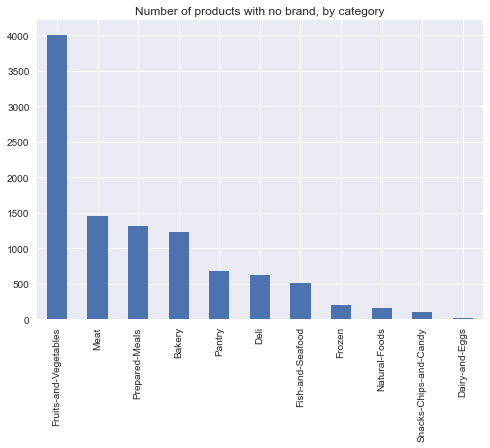

In [110]:
# How many products don't have a brand by category
df[df['productBrand'].isnull()]['category'].value_counts().plot(kind='bar')
plt.title('Number of products with no brand, by category');

<a id='deal_id'></a>
#### Deal badge (sales)

In [18]:
# check out dealBadge possible values:
df['dealBadge'].unique()

array([nan, 'sale', 'multi'], dtype=object)

In [19]:
# Which products have a deal
# Dataframe containing products with price discounts: multi or individual sale

deals = ['multi', 'sale']
deals_df_lst = []

for deal in deals:
    deals_df_lst.append(df[df['dealBadge'] == deal])
    
deals_df = pd.concat(deals_df_lst) #create a dataframe with every product that has a deal

In [20]:
deals_df

,productSKU,productName,productBrand,productPrice,dealBadge,loyaltyBadge,textBadge,category,store,scrape_date
24,21362495_EA,Organic Lime Strawberry Kombucha,NaN,3.49,multi,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-05
65,21416561001_EA,Orange,NaN,0.35,multi,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-05
93,21335195_EA,Organic Mango Passionfruit Kombucha,Remedy,4.99,multi,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-05
126,21362519_EA,Organic Pink Grapefruit Smoothie,NaN,3.49,multi,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-05
179,21378122_EA,Loads Of Garlic Caesar Salad Kit,President's Choice,6.49,multi,False,low-stock,Fruits-and-Vegetables,loblaws,2022-10-05
...,...,...,...,...,...,...,...,...,...,...
23795,21203977_EA,Tomato and Mozzarella Skillet Gnocchi,Olivieri,5.79,sale,False,NaN,Prepared-Meals,nofrills,2022-10-12
23798,21401776_EA,Creamy Chicken and Vegetable Pot Pie,Farmer's Market,6.00,sale,False,NaN,Prepared-Meals,nofrills,2022-10-12
23799,21401995_EA,Pork and Beef Tourtiere,Farmer's Market,6.00,sale,False,NaN,Prepared-Meals,nofrills,2022-10-12
23808,21021520_EA,Skillet Gnocchi,Olivieri,5.79,sale,False,NaN,Prepared-Meals,nofrills,2022-10-12


In [21]:
# filter out for the most recent date and create a dataframe of the latest deals
latest_deals_df = deals_df[deals_df['scrape_date'] == date_lst[-1]].drop_duplicates().copy()

In [22]:
latest_deals_df

,productSKU,productName,productBrand,productPrice,dealBadge,loyaltyBadge,textBadge,category,store,scrape_date
8,20040489001_EA,Limes,NaN,0.99,multi,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12
36,21290591_EA,Peach Kombucha,Remedy,4.99,multi,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12
39,21416561001_EA,Orange,NaN,0.35,multi,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12
92,21362499_EA,Organic Raspberry Lemon Kombucha,NaN,3.49,multi,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12
134,21378024_EA,Bacon Caesar Chop Salad Kit,President's Choice,6.49,multi,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12
...,...,...,...,...,...,...,...,...,...,...
23795,21203977_EA,Tomato and Mozzarella Skillet Gnocchi,Olivieri,5.79,sale,False,NaN,Prepared-Meals,nofrills,2022-10-12
23798,21401776_EA,Creamy Chicken and Vegetable Pot Pie,Farmer's Market,6.00,sale,False,NaN,Prepared-Meals,nofrills,2022-10-12
23799,21401995_EA,Pork and Beef Tourtiere,Farmer's Market,6.00,sale,False,NaN,Prepared-Meals,nofrills,2022-10-12
23808,21021520_EA,Skillet Gnocchi,Olivieri,5.79,sale,False,NaN,Prepared-Meals,nofrills,2022-10-12


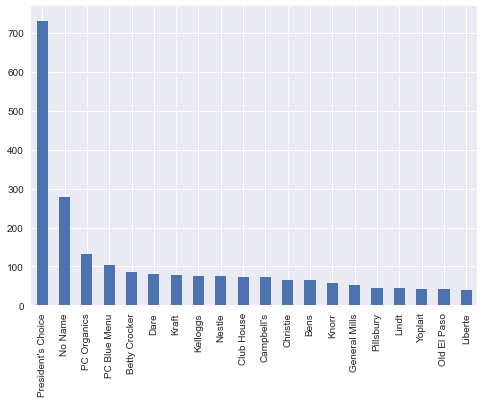

In [23]:
# visualize top 20 product brands on sale across both stores (latest date)
latest_deals_df['productBrand'].value_counts().head(20).plot(kind='bar');

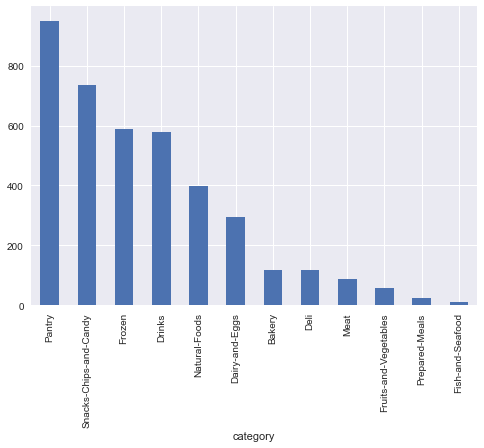

In [24]:
# Deal count by category for loblaws
latest_deals_df[latest_deals_df['store'] == 'loblaws'].groupby('category')['productSKU'].count().sort_values(ascending=False).plot(kind='bar');

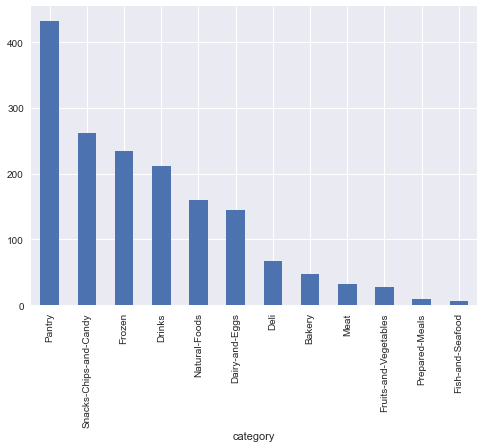

In [112]:
# Deal count by category for nofrills
latest_deals_df[latest_deals_df['store'] == 'nofrills'].groupby('category')['productSKU'].count().sort_values(ascending=False).plot(kind='bar');

In [25]:
# pivot table of deal counts
latest_deals_df.groupby(['store','category'])['productSKU'].count().unstack(0)

store,loblaws,nofrills
category,,
Bakery,117,48
Dairy-and-Eggs,294,145
Deli,117,68
Drinks,577,212
Fish-and-Seafood,11,6
Frozen,588,235
Fruits-and-Vegetables,58,28
Meat,87,33
Natural-Foods,398,160


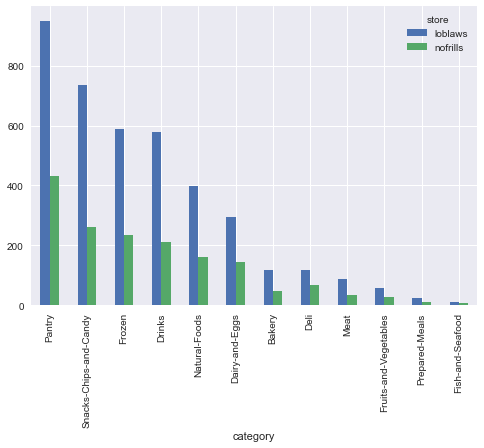

In [26]:
# Display the count of deals by category for both stores
latest_deals_df.groupby(['store','category'])['productSKU'].count().unstack(0).sort_values(by='loblaws', ascending=False).plot(kind='bar');

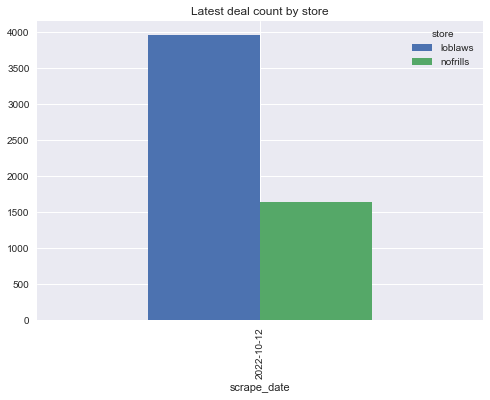

In [113]:
# Latest Price Deal count by store
ax = latest_deals_df.groupby(['store', 'scrape_date'])['productSKU'].count().unstack(0).plot(kind='bar')

# remove the 00:00:00 from the date time in the x axis
ax.set_xticklabels(latest_deals_df.groupby(['store', 'scrape_date'])['productSKU'].count().unstack(0).index.format());

plt.title('Latest deal count by store');

<a id='low_stock_id'></a>
#### Low stock, new product badge 

In [28]:
# Check out the textBadge which shows if a product is new or has low-stock, or both
df['textBadge'].value_counts()

low-stock        12357
new               2589
new|low-stock      283
Name: textBadge, dtype: int64

In [29]:
# Daily count of new & low stock badges
df.groupby(['store', 'scrape_date'])['textBadge'].value_counts().unstack()

textBadge             low-stock  new  new|low-stock
store    scrape_date                               
loblaws  2022-10-05        1171  216             27
         2022-10-06        1219  230             36
         2022-10-07        1231  231             29
         2022-10-08        1184  234             22
         2022-10-09        1303  240             37
         2022-10-10        1197  223             29
         2022-10-11        1296  192             29
         2022-10-12        1078  232             24
nofrills 2022-10-05         351   98              3
         2022-10-06         256  101              5
         2022-10-07         275  100              5
         2022-10-08         345   99              6
         2022-10-09         472  102             10
         2022-10-10         342  102             10
         2022-10-11         366   96              7
         2022-10-12         271   93              4

In [30]:
# show the textBadge daily totals
df[df['textBadge'] == 'low-stock'].groupby(['store', 'scrape_date'])['textBadge'].count().unstack()

scrape_date,2022-10-05,2022-10-06,2022-10-07,2022-10-08,2022-10-09,2022-10-10,2022-10-11,2022-10-12
store,,,,,,,,
loblaws,1171,1219,1231,1184,1303,1197,1296,1078
nofrills,351,256,275,345,472,342,366,271


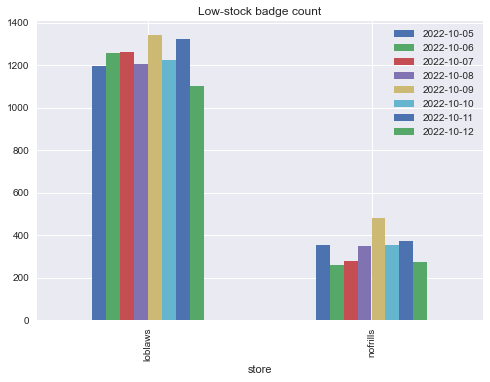

In [101]:
# as the week progresses, how does the low-stock count look
df[(df['textBadge'] == 'low-stock') | (df['textBadge'] == 'new|low-stock')].groupby(['store', 'scrape_date'])['textBadge'].count().unstack().plot(kind='bar')

# format the legend to remove the 00:00:00 from the timestamp
plt.legend(df[(df['textBadge'] == 'low-stock') | (df['textBadge'] == 'new|low-stock')].groupby(['store', 'scrape_date'])['textBadge'].count().unstack().columns.format())

plt.title('Low-stock badge count');

<a id='loyalty_id'></a>
#### Loyalty badge (PC points)

In [32]:
# Check out the loyalty (PC Optimum points) boolean
df['loyaltyBadge'].value_counts()

False    150115
True       4939
Name: loyaltyBadge, dtype: int64

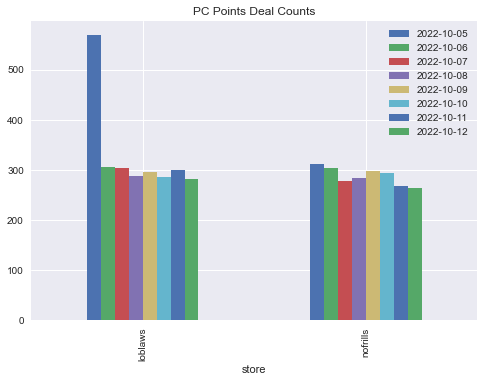

In [33]:
# visualize the loyalty product counts for the week
df[df['loyaltyBadge'] == True].groupby(['store', 'scrape_date'])['loyaltyBadge'].count().unstack().plot(kind='bar')

# format the legend to remove the 00:00:00 from the timestamp
plt.legend(df[df['loyaltyBadge'] == True].groupby(['store', 'scrape_date'])['loyaltyBadge'].count().unstack().columns.format())

plt.title('PC Points Deal Counts');

In [34]:
# Daily total count of products with bonus PC Optimum points
pc_points_df = df.groupby(['store', 'scrape_date'])['loyaltyBadge'].value_counts().unstack(1)
pc_points_df

scrape_date            2022-10-05  2022-10-06  2022-10-07  2022-10-08  \
store    loyaltyBadge                                                   
loblaws  False              11803       12726       11946       11793   
         True                 569         306         304         288   
nofrills False               6897        7181        6698        6580   
         True                 312         305         279         285   

scrape_date            2022-10-09  2022-10-10  2022-10-11  2022-10-12  
store    loyaltyBadge                                                  
loblaws  False              12438       11891       11280       11906  
         True                 297         286         300         282  
nofrills False               6959        6784        6495        6738  
         True                 298         294         269         265

<a id='brand_id'></a>
### 3.4 Brand Counts

In [35]:
# Unique brand counts by store (latest)
unique_brands_df = latest_df.groupby('store')[['productBrand']].nunique()
unique_brands_df

,productBrand
store,
loblaws,1332
nofrills,802


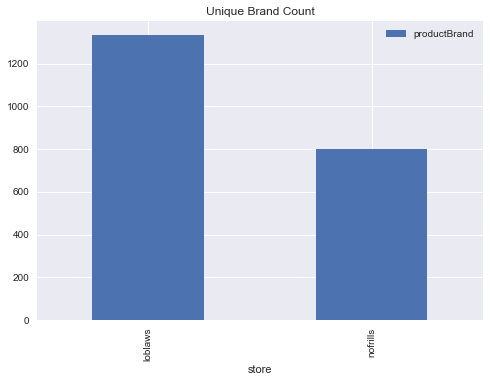

In [115]:
unique_brands_df.plot(kind='bar')
plt.title('Unique Brand Count');

In [37]:
# Use plotly for an interactive, presentable bar graph
data = go.Bar(x=unique_brands_df.index, y=unique_brands_df['productBrand'],
              marker=dict(color=['#e1251b', 'rgb(255, 215, 0)'])) # set loblaws and nofrills colors

fig = go.Figure(data)
fig.update_layout(title_text="Unique Brand Count by Store")
fig.show()

<a id='product_id'></a>
### 3.5 Product Counts

In [38]:
# get unique product counts by store
unique_products_df = latest_df.groupby('store')[['productSKU']].nunique()
unique_products_df

,productSKU
store,
loblaws,11846
nofrills,6793


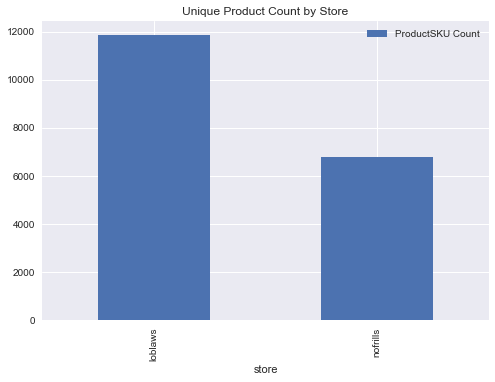

In [39]:
unique_products_df.plot(kind='bar')
plt.legend(['ProductSKU Count'])
plt.title('Unique Product Count by Store');

In [40]:
data = go.Bar(x=unique_products_df.index, y=unique_products_df['productSKU'],
              marker=dict(color=['#e1251b', 'rgb(255, 215, 0)']))

fig = go.Figure(data)
fig.update_layout(title_text="Unique Product Count by Store")
fig.show()

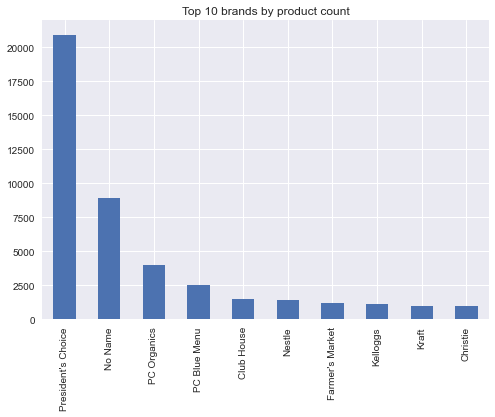

In [41]:
# top 10 brands by product count across both stores
df['productBrand'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 brands by product count');

**Insight:** Loblaw owns the top 4 product brands (by count) in their stores. The third-party with the highest product count is 'Club House' spices (McCormick Canada).

In [42]:
# Unique Product counts day by day
df.groupby(['store', 'scrape_date'])[['productSKU']].nunique().unstack(0)

productSKU         
store          loblaws nofrills
scrape_date                    
2022-10-05       11988     6955
2022-10-06       12620     7230
2022-10-07       11868     6740
2022-10-08       11712     6646
2022-10-09       12337     7033
2022-10-10       11834     6863
2022-10-11       11228     6565
2022-10-12       11846     6793

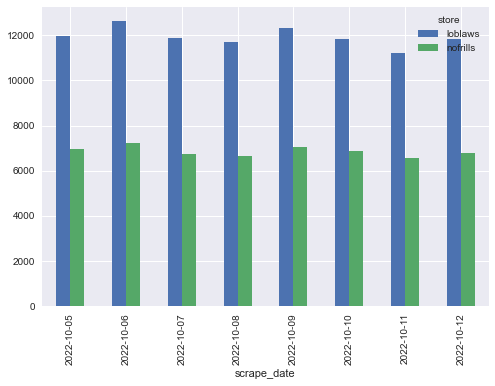

In [43]:
# Number of unique products in each store (daily)
ax = df.groupby(['store', 'scrape_date'])['productSKU'].nunique().unstack(0).plot(kind='bar')

# remove the 00:00:00 from the date time in the x axis
ax.set_xticklabels(df.groupby(['store', 'scrape_date'])['productSKU'].nunique().unstack(0).index.format());

In [44]:
# find the latest unique product count by category
latest_df.groupby(['store', 'category'])[['productSKU']].nunique().unstack(0)

productSKU         
store                     loblaws nofrills
category                                  
Bakery                        524      295
Dairy-and-Eggs                820      518
Deli                          878      428
Drinks                       1310      783
Fish-and-Seafood              149       74
Frozen                       1253      779
Fruits-and-Vegetables         588      390
Meat                          467      308
Natural-Foods                1259      776
Pantry                       3146     1818
Prepared-Meals                362      107
Snacks-Chips-and-Candy       1432      727

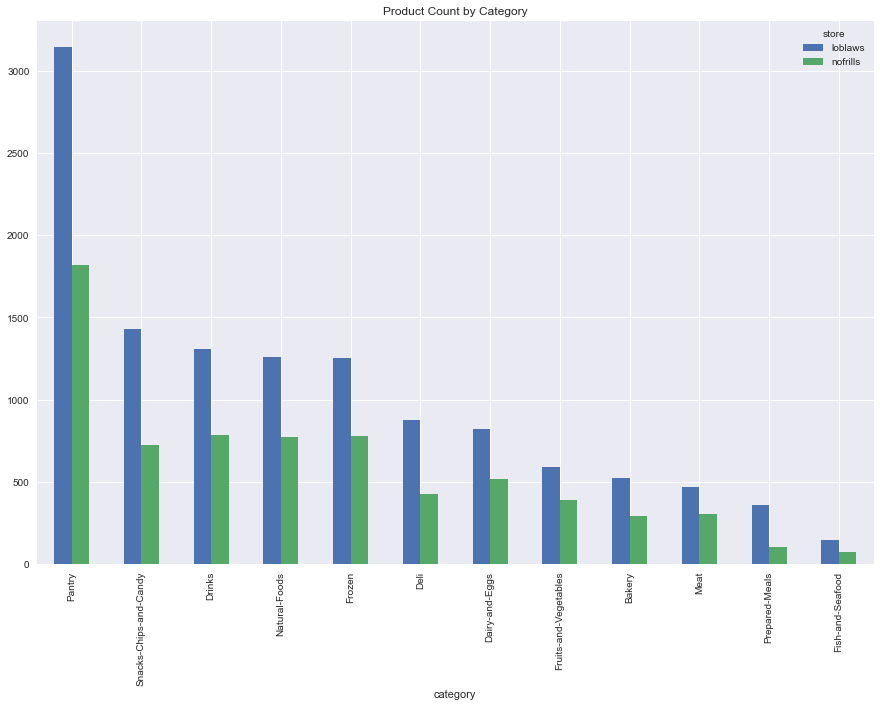

In [45]:
# Latest product count by category
latest_df.groupby(['store', 'category'])['productSKU'].nunique().unstack(0).sort_values(by='loblaws', ascending=False).plot(kind='bar', figsize=(15,10))
plt.title('Product Count by Category');

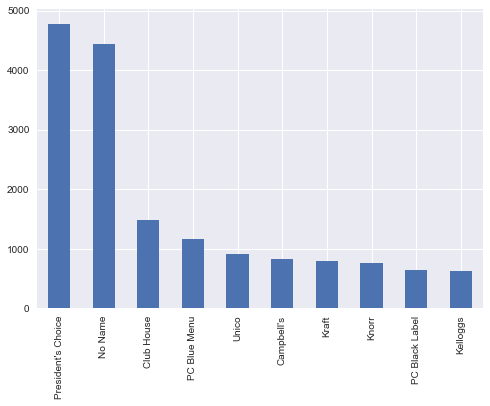

In [47]:
# Amount of each product brand in a category - top 10, ex: Pantry
df[df['category'] == 'Pantry']['productBrand'].value_counts().head(10).plot(kind='bar');

<a id='dist_id'></a>
### 3.6 Product Distribution by Category

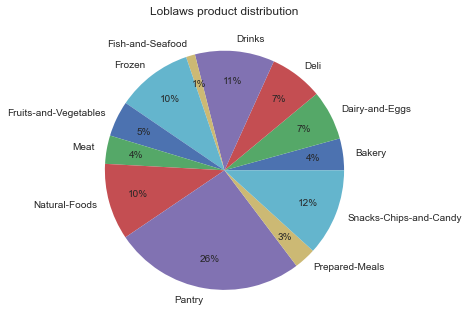

In [48]:
# LOBLAWS: product distribution by category
plt.pie(latest_df[latest_df['store'] == 'loblaws'].groupby('category')['productSKU'].count(), labels=latest_df[latest_df['store'] == 'loblaws'].groupby('category')['productSKU'].count().index, autopct='%1.0f%%', pctdistance=0.75)
plt.title('Loblaws product distribution');

In [49]:
# Plotly version for interactive presentation
data = latest_df[latest_df['store'] == 'loblaws'].groupby('category')['productSKU'].count()
fig = go.Figure(data=[go.Pie(labels=data.index, values=data.values)])
fig.update_traces(textposition='inside', textinfo='percent+label', title_text="Loblaws Product Distribution")
fig.show()

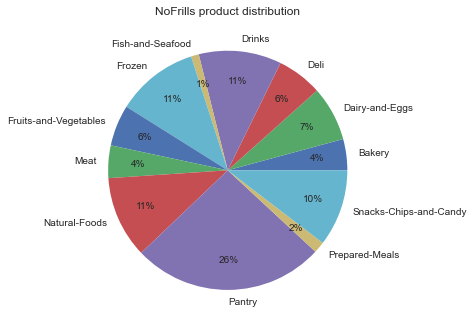

In [52]:
# NOFRILLS: product distribution by category
plt.pie(latest_df[latest_df['store'] == 'nofrills'].groupby('category')['productSKU'].count(), labels=latest_df[latest_df['store'] == 'nofrills'].groupby('category')['productSKU'].count().index, autopct='%1.0f%%', pctdistance=0.75)
plt.title('NoFrills product distribution');

In [53]:
# Plotly version for interactive presentation
data = latest_df[latest_df['store'] == 'nofrills'].groupby('category')['productSKU'].count()
fig = go.Figure(data=[go.Pie(labels=data.index, values=data.values)])
fig.update_traces(textposition='inside', textinfo='percent+label', title_text="NoFrills Product Distribution")
fig.show()

The product distributions across the store categories are almost identical. There are some minor differences, as you can see some categories are swapped on the pie graphs, but these differences are around 2% or less, so they are essentially balanced in both stores.


What does this tell us? Well, Loblaws, being around for over a hundred years, must have done a lot of research as to their customers’ spending habits, and this product distribution is most likely optimal to meet customer demands and maximize their sales.


What fascinates me is this balance of products. I am very curious to know if it is unique to Loblaw companies or if other large grocers have similar distributions for their product categories.

<a id='match_id'></a>
### 3.7 Matching ProductSKU in both stores

In [54]:
# Get matching productSKUs for direct price comparison for the most recent date
loblaws_df = latest_df[latest_df['store'] == 'loblaws'].drop_duplicates()
loblaws_df

nofrills_df = latest_df[latest_df['store'] == 'nofrills'].drop_duplicates()
nofrills_df

,productSKU,productName,productBrand,productPrice,dealBadge,loyaltyBadge,textBadge,category,store,scrape_date
722,20175355001_KG,"Bananas, Bunch",NaN,1.50,NaN,False,NaN,Fruits-and-Vegetables,nofrills,2022-10-12
723,20107500001_EA,Green Onion,NaN,1.69,NaN,False,NaN,Fruits-and-Vegetables,nofrills,2022-10-12
724,20163119001_EA,Celery Stalks,NaN,2.49,NaN,False,NaN,Fruits-and-Vegetables,nofrills,2022-10-12
725,20117550001_EA,Sweet Baby Peppers,Farmer's Market,3.99,NaN,False,NaN,Fruits-and-Vegetables,nofrills,2022-10-12
726,20135326001_EA,Lettuce Iceberg,NaN,2.49,NaN,False,NaN,Fruits-and-Vegetables,nofrills,2022-10-12
...,...,...,...,...,...,...,...,...,...,...
23812,21414456_EA,Bourbon Bacon,Taylor Farms,4.99,NaN,False,NaN,Prepared-Meals,nofrills,2022-10-12
23813,20084505_EA,Potato & Egg Salad,Ziggy's,3.99,NaN,False,NaN,Prepared-Meals,nofrills,2022-10-12
23814,21401761_EA,Quiche Florentine,Farmer's Market,6.00,sale,False,NaN,Prepared-Meals,nofrills,2022-10-12
23815,21378594_EA,Crispy Chicken Spring Rolls,Sum-m,4.69,NaN,False,NaN,Prepared-Meals,nofrills,2022-10-12


In [55]:
matching_products_df = pd.merge(loblaws_df,
                                nofrills_df,
                                on='productSKU',
                                how='inner', suffixes=['_loblaws', '_nofrills']).drop_duplicates(subset='productSKU')
match_df = matching_products_df.copy()

In [56]:
match_df.columns

Index(['productSKU', 'productName_loblaws', 'productBrand_loblaws',
       'productPrice_loblaws', 'dealBadge_loblaws', 'loyaltyBadge_loblaws',
       'textBadge_loblaws', 'category_loblaws', 'store_loblaws',
       'scrape_date_loblaws', 'productName_nofrills', 'productBrand_nofrills',
       'productPrice_nofrills', 'dealBadge_nofrills', 'loyaltyBadge_nofrills',
       'textBadge_nofrills', 'category_nofrills', 'store_nofrills',
       'scrape_date_nofrills'],
      dtype='object')

In [57]:
match_df

,productSKU,productName_loblaws,productBrand_loblaws,productPrice_loblaws,dealBadge_loblaws,loyaltyBadge_loblaws,textBadge_loblaws,category_loblaws,store_loblaws,scrape_date_loblaws,productName_nofrills,productBrand_nofrills,productPrice_nofrills,dealBadge_nofrills,loyaltyBadge_nofrills,textBadge_nofrills,category_nofrills,store_nofrills,scrape_date_nofrills
0,20007535001_KG,Red Peppers,NaN,2.11,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12,Red Peppers,NaN,1.58,NaN,False,NaN,Fruits-and-Vegetables,nofrills,2022-10-12
1,20425893001_KG,Sweet Green Peppers,NaN,1.11,sale,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12,Sweet Green Peppers,NaN,1.23,NaN,False,NaN,Fruits-and-Vegetables,nofrills,2022-10-12
2,20143381001_KG,Roma Tomatoes,NaN,0.47,sale,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12,Roma Tomatoes,NaN,0.53,NaN,False,low-stock,Fruits-and-Vegetables,nofrills,2022-10-12
3,20134101001_KG,Red Onion,NaN,2.44,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12,Red Onion,NaN,2.03,NaN,False,NaN,Fruits-and-Vegetables,nofrills,2022-10-12
4,20600927001_EA,Carrots,Farmer's Market,1.29,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12,Carrots,Farmer's Market,2.49,NaN,False,NaN,Fruits-and-Vegetables,nofrills,2022-10-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4923,20132121_EA,Basil & Cheese Pesto,Olivieri,6.29,NaN,False,NaN,Prepared-Meals,loblaws,2022-10-12,Basil & Cheese Pesto,Olivieri,4.99,NaN,False,NaN,Prepared-Meals,nofrills,2022-10-12
4924,21021520_EA,Skillet Gnocchi,Olivieri,6.49,NaN,False,NaN,Prepared-Meals,loblaws,2022-10-12,Skillet Gnocchi,Olivieri,5.79,sale,False,NaN,Prepared-Meals,nofrills,2022-10-12
4925,20084505_EA,Potato & Egg Salad,Ziggy's,3.99,NaN,False,NaN,Prepared-Meals,loblaws,2022-10-12,Potato & Egg Salad,Ziggy's,3.99,NaN,False,NaN,Prepared-Meals,nofrills,2022-10-12
4926,21401761_EA,Quiche Florentine,Farmer's Market,7.49,NaN,False,NaN,Prepared-Meals,loblaws,2022-10-12,Quiche Florentine,Farmer's Market,6.00,sale,False,NaN,Prepared-Meals,nofrills,2022-10-12


In [58]:
# Compare prices of same product in both stores

In [59]:
# create a copy of the matching products dataframe with the desired columns
price_compare_df = match_df[['productSKU', 'category_loblaws', 'productName_loblaws', 'productPrice_loblaws', 'productPrice_nofrills']].copy()

# rename the columns for clarity
price_compare_df.rename(columns={'category_loblaws': 'category', 'productName_loblaws': 'productName'}, inplace=True)

# create a dollar difference column
price_compare_df['dollar_diff'] = price_compare_df['productPrice_loblaws'] - price_compare_df['productPrice_nofrills']

# create a 'percent difference' column
price_compare_df['percent_diff'] = abs((price_compare_df['productPrice_loblaws'] - price_compare_df['productPrice_nofrills']) * 100) / ((price_compare_df['productPrice_loblaws'] + price_compare_df['productPrice_nofrills']) / 2)

price_compare_df

,productSKU,category,productName,productPrice_loblaws,productPrice_nofrills,dollar_diff,percent_diff
0,20007535001_KG,Fruits-and-Vegetables,Red Peppers,2.11,1.58,0.53,28.726287
1,20425893001_KG,Fruits-and-Vegetables,Sweet Green Peppers,1.11,1.23,-0.12,10.256410
2,20143381001_KG,Fruits-and-Vegetables,Roma Tomatoes,0.47,0.53,-0.06,12.000000
3,20134101001_KG,Fruits-and-Vegetables,Red Onion,2.44,2.03,0.41,18.344519
4,20600927001_EA,Fruits-and-Vegetables,Carrots,1.29,2.49,-1.20,63.492063
...,...,...,...,...,...,...,...
4923,20132121_EA,Prepared-Meals,Basil & Cheese Pesto,6.29,4.99,1.30,23.049645
4924,21021520_EA,Prepared-Meals,Skillet Gnocchi,6.49,5.79,0.70,11.400651
4925,20084505_EA,Prepared-Meals,Potato & Egg Salad,3.99,3.99,0.00,0.000000
4926,21401761_EA,Prepared-Meals,Quiche Florentine,7.49,6.00,1.49,22.090437


In [60]:
# Average prices per category
avg_price_compare_df = price_compare_df.groupby('category').mean().sort_values(by='productPrice_loblaws', ascending=False).copy()

# set the percent difference to be equal to the differerence of the average category prices
avg_price_compare_df['percent_diff'] = abs((avg_price_compare_df['productPrice_loblaws'] - avg_price_compare_df['productPrice_nofrills']) * 100) / ((avg_price_compare_df['productPrice_loblaws'] + avg_price_compare_df['productPrice_nofrills']) / 2)

avg_price_compare_df

,productPrice_loblaws,productPrice_nofrills,dollar_diff,percent_diff
category,,,,
Meat,12.689364,12.085896,0.603468,4.871539
Fish-and-Seafood,9.976757,9.652162,0.324595,3.307310
Deli,7.972869,7.295219,0.677649,8.876677
Frozen,6.965586,6.333117,0.632469,9.511734
Natural-Foods,6.815304,6.588036,0.227267,3.391203
Drinks,5.784012,5.125432,0.658580,12.073570
Prepared-Meals,5.585122,4.763902,0.821220,15.870472
Dairy-and-Eggs,5.497213,5.040164,0.457049,8.674819
Pantry,4.940586,4.271094,0.669492,14.535717


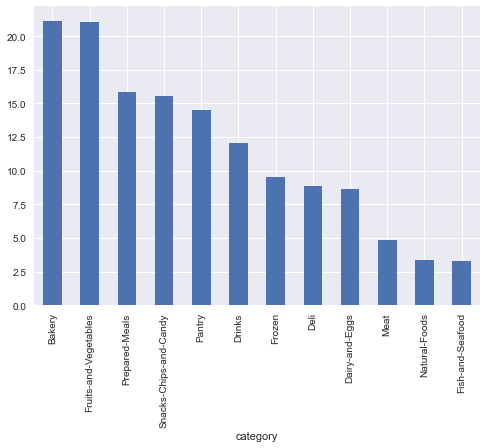

In [61]:
# Visualize avg percent diff by category
avg_price_compare_df.groupby('category')['percent_diff'].mean().sort_values(ascending=False).plot(kind='bar');

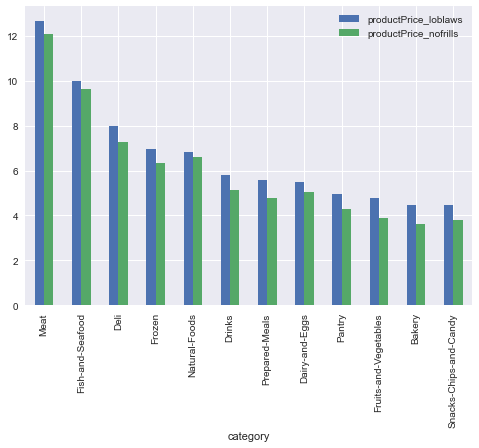

In [62]:
# dollar average by category
avg_price_compare_df.groupby('category')[['productPrice_loblaws', 'productPrice_nofrills']].mean().sort_values(by='productPrice_loblaws', ascending=False).plot(kind='bar');

In [105]:
# Plotly visualize both store average prices by category and percent diff overlay
trace_loblaw = go.Bar(
    x=avg_price_compare_df.groupby('category').mean().sort_values(by='productPrice_loblaws', ascending=False).index,
    y=avg_price_compare_df.groupby('category').mean().sort_values(by='productPrice_loblaws', ascending=False)['productPrice_loblaws'].values,
    name='Loblaws',
    marker=dict(color='#e1251b')
)

trace_nofrills= go.Bar(
    x=avg_price_compare_df.groupby('category').mean().sort_values(by='productPrice_loblaws', ascending=False).index,
    y=avg_price_compare_df.groupby('category').mean().sort_values(by='productPrice_loblaws', ascending=False)['productPrice_nofrills'].values,
    name='NoFrills',
    marker=dict(color='rgb(255, 215, 0)')
)

trace_percent_diff = go.Scatter(x=avg_price_compare_df.groupby('category').mean().sort_values(by='productPrice_loblaws', ascending=False).index, y=avg_price_compare_df.groupby('category').mean().sort_values(by='productPrice_loblaws', ascending=False)['percent_diff'].values, line=dict(color='teal'), name='Percent Difference')

data = [trace_loblaw, trace_nofrills, trace_percent_diff]


fig = go.Figure(data=data)
fig.update_layout(title_text="Average product price by category")

py.iplot(fig)

I took the average price of a product per category and compared it between both stores. This gives me a general idea of how much more I am saving on average by shopping at Nofrills.


I overlaid the bar chart with a line graph, which shows the percent difference in the average prices.


You can see that meat, fish, and natural foods are priced very similarly. At Nofrills, the average savings is less than 5%.


However, when we look at prepared-meals, pantry, and snacks, we start saving around 15% on average.


The best savings are in fruits, vegetables, and the bakery. We are saving over 20% on average.

In [65]:
# check products price diff for products that cost more at loblaws
price_comp_loblaws = price_compare_df[(price_compare_df['productPrice_loblaws'] > price_compare_df['productPrice_nofrills']) & price_compare_df['percent_diff'] > 0].sort_values('percent_diff', ascending=False).copy()
price_comp_loblaws

,productSKU,category,productName,productPrice_loblaws,productPrice_nofrills,dollar_diff,percent_diff
2353,20866838_EA,Snacks-Chips-and-Candy,Roasted Seaweed,4.19,1.50,2.69,94.551845
1832,20310507001_EA,Pantry,Turkey Stuffing Mix,2.29,0.89,1.40,88.050314
1043,20162036_EA,Pantry,Yellow Mustard,2.49,0.99,1.50,86.206897
1031,20323721011_EA,Pantry,"Seasoning Mix, Shepherd's Pie",2.49,0.99,1.50,86.206897
1023,20302816007_EA,Pantry,"Dry Sauce Mix, Turkey Gravy, Less Salt",2.49,0.99,1.50,86.206897
...,...,...,...,...,...,...,...
3622,21165332_EA,Frozen,Stuffed Crust 4 Cheese Pizza,8.49,8.39,0.10,1.184834
3454,21364392_EA,Frozen,Lemon Garlic Shrimp & Scallop Pasta Meal Kit,16.99,16.79,0.20,1.184133
1755,21401911_EA,Pantry,Almond Flour,17.99,17.79,0.20,1.117943
595,20054844_EA,Dairy-and-Eggs,Organic Homogenized Milk,10.39,10.29,0.10,0.967118


In [66]:
# check products price diff for products that cost more at nofrills
price_comp_nofrills = price_compare_df[(price_compare_df['productPrice_nofrills'] > price_compare_df['productPrice_loblaws']) & price_compare_df['percent_diff'] > 0].copy()
price_comp_nofrills

,productSKU,category,productName,productPrice_loblaws,productPrice_nofrills,dollar_diff,percent_diff
1,20425893001_KG,Fruits-and-Vegetables,Sweet Green Peppers,1.11,1.23,-0.12,10.256410
2,20143381001_KG,Fruits-and-Vegetables,Roma Tomatoes,0.47,0.53,-0.06,12.000000
4,20600927001_EA,Fruits-and-Vegetables,Carrots,1.29,2.49,-1.20,63.492063
75,21093267_EA,Fruits-and-Vegetables,"Raw, Unsalted Pumpkin Seeds",1.99,2.49,-0.50,22.321429
79,20711275001_KG,Fruits-and-Vegetables,Adora Seedless® Black Grapes,6.01,12.06,-6.05,66.961815
...,...,...,...,...,...,...,...
4799,21447518_EA,Bakery,Protein Tortillas,3.49,3.79,-0.30,8.241758
4800,20120773_EA,Bakery,Pumpernickel Bread,3.79,3.89,-0.10,2.604167
4805,21245347_EA,Bakery,Gluten Free White Bread,3.99,5.49,-1.50,31.645570
4811,21416545_EA,Bakery,Original Pizza Crusts,3.49,3.69,-0.20,5.571031


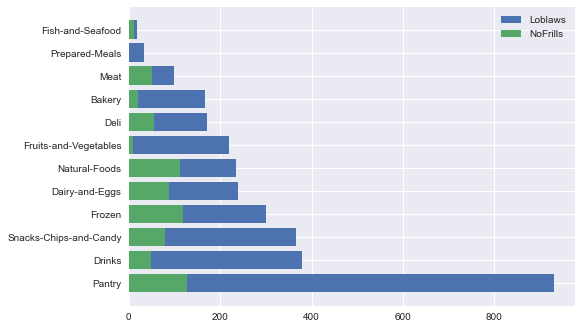

In [67]:
# Visualize the price differences in a horizontal bar chart
plt.barh(price_comp_loblaws.groupby('category')['productSKU'].count().sort_values(ascending=False).index, price_comp_loblaws.groupby('category')['productSKU'].count().sort_values(ascending=False).values, label = 'Loblaws')
plt.barh(price_comp_nofrills.groupby('category')['productSKU'].count().sort_values(ascending=False).index, price_comp_nofrills.groupby('category')['productSKU'].count().sort_values(ascending=False).values, label = 'NoFrills')
plt.legend()

In [104]:
# Plotly visualize higher product price count by category
trace_loblaw = go.Bar(
    x=price_comp_loblaws.groupby('category')['productSKU'].count().sort_values(ascending=False).index,
    y=price_comp_loblaws.groupby('category')['productSKU'].count().sort_values(ascending=False).values,
    name='Loblaws',
    marker=dict(color='#e1251b')
)
trace_nofrills = go.Bar(
    x=price_comp_nofrills.groupby('category')['productSKU'].count().sort_values(ascending=False).index,
    y=price_comp_nofrills.groupby('category')['productSKU'].count().sort_values(ascending=False).values,
    name='NoFrills',
    marker=dict(color='rgb(255, 215, 0)')
)

data = [trace_loblaw, trace_nofrills]

layout = go.Layout(
        title="Higher price for same product",
        xaxis=dict(title='Category'),
        yaxis=dict(title='Product count'))

fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

I matched the productSKU at both stores, and I did my due diligence to confirm it was the same product and brand.


Then I ran a count as to how many products, which are exactly the same, cost more at Loblaws and how many at Nofrills.


I thought there would be all red bars (ie. Loblaws), because I know products cost more at Loblaws. But I was surprised to see a lot of yellow bars there.

Nofrills actually has a lot of products that cost more than Loblaws.


In general, though, you can see that for the same product, chances are you are going to pay more at Loblaws.

<a id='prices_id'></a>
### 3.8 Product Prices

In [69]:
# Average product price by store, daily
avg_price_df = df.groupby(['store', 'scrape_date'])['productPrice'].mean().unstack(1)
avg_price_df

scrape_date,2022-10-05,2022-10-06,2022-10-07,2022-10-08,2022-10-09,2022-10-10,2022-10-11,2022-10-12
store,,,,,,,,
loblaws,6.878244,6.806698,6.867013,6.852617,6.905235,6.862340,6.894687,6.849076
nofrills,5.594105,5.544068,5.585018,5.574942,5.579114,5.558914,5.511993,5.540523


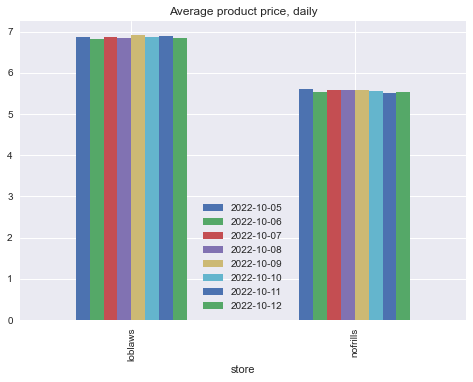

In [70]:
# Visualize the daily average of all product prices
avg_price_df.plot(kind='bar')

# remove the 00:00:00 from the legend
plt.legend(avg_price_df.columns.format())

plt.title('Average product price, daily');

In [71]:
# Visualize the category prices via box plots
data = go.Box(x=latest_df['category'],
              y=latest_df['productPrice'],
              boxpoints='all',
              name='ProductPrices')

Layout = go.Layout(
    yaxis = {'title':'Product Price'}
)

fig = go.Figure(data=[data], layout=Layout)
py.iplot(fig)

# The visualization is very compressed due to some very expensive outliers in the meat and deli categories

In [72]:
# Revisualized with a max price limit of $30
data = go.Box(x=latest_df['category'],
              y=latest_df[latest_df['productPrice'] < 30]['productPrice'],
              boxpoints='all',
              name='ProductPrices')

Layout = go.Layout(
    yaxis = {'title':'Product Price'}
)

fig = go.Figure(data=[data], layout=Layout)
py.iplot(fig)

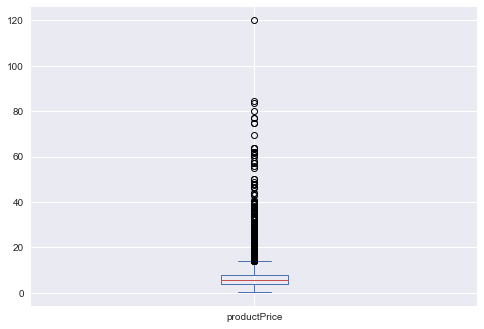

In [73]:
# box plot latest product prices in Loblaws
latest_df[latest_df['store'] == 'loblaws']['productPrice'].plot(kind='box');

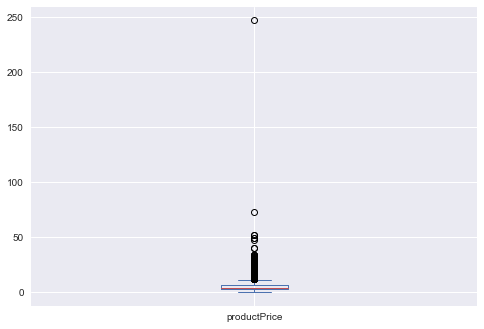

In [74]:
# box plot latest product prices in NoFrills
latest_df[latest_df['store'] == 'nofrills']['productPrice'].plot(kind='box');

In [75]:
# what are these expensive outliers? Find any individual product that costs over $60
latest_df[latest_df['productPrice'] > 60].sort_values(by='productPrice', ascending=False)

,productSKU,productName,productBrand,productPrice,dealBadge,loyaltyBadge,textBadge,category,store,scrape_date
9925,21192446_KG,Certified Angus Beef Whole Beef Tenderloin,President's Choice,246.85,NaN,False,NaN,Meat,nofrills,2022-10-12
21119,20799103_EA,Silver Whole Prosciutto,NaN,120.00,NaN,False,NaN,Deli,loblaws,2022-10-12
9667,20798406_KG,"Beef Brisket, Point Cut, Boneless",NaN,84.33,NaN,False,NaN,Meat,loblaws,2022-10-12
9563,20006062_KG,Fresh Turkey 9 - 11 Kg,Butterball,83.50,NaN,False,NaN,Meat,loblaws,2022-10-12
9719,20812304_KG,Prime Beef Rib Premium Oven Roast,NaN,80.16,NaN,False,NaN,Meat,loblaws,2022-10-12
9523,21286261_EA,Frozen Turkey 9-11 Kg,Butterball,77.00,NaN,False,low-stock,Meat,loblaws,2022-10-12
15849,21286261_EA,Frozen Turkey 9-11 Kg,Butterball,77.00,NaN,False,NaN,Frozen,loblaws,2022-10-12
17029,21284944_EA,Butter Infused Young Turkey - Frozen - 9-11kg,President's Choice,75.00,NaN,False,NaN,Frozen,loblaws,2022-10-12
9688,21284944_EA,Butter Infused Young Turkey - Frozen - 9-11kg,President's Choice,75.00,NaN,False,low-stock,Meat,loblaws,2022-10-12
9991,21456080_KG,Free From Grass Fed Australian Angus Beef Tend...,President's Choice,72.73,NaN,False,NaN,Meat,nofrills,2022-10-12


In [76]:
# what are the cheapest items? All items under $0.40
latest_df[latest_df['productPrice'] < 0.4].sort_values(by='productPrice', ascending=False)

,productSKU,productName,productBrand,productPrice,dealBadge,loyaltyBadge,textBadge,category,store,scrape_date
8317,20802664_EA,"Noodles, Masala",Maggi,0.39,multi,False,NaN,Pantry,nofrills,2022-10-12
39,21416561001_EA,Orange,NaN,0.35,multi,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12
787,20142683001_KG,Green Beans,NaN,0.33,NaN,False,NaN,Fruits-and-Vegetables,nofrills,2022-10-12
996,20096584001_KG,Cremini Mushrooms,NaN,0.33,NaN,False,NaN,Fruits-and-Vegetables,nofrills,2022-10-12
6970,20301274002_EA,Beef Flavour Instant Noodle Soup,No Name,0.33,NaN,False,NaN,Pantry,nofrills,2022-10-12
7046,20301274001_EA,Chicken Flavour Instant Noodle Soup,No Name,0.33,NaN,False,NaN,Pantry,nofrills,2022-10-12
7807,20040005_EA,Shrimp Flavour Instant Noodle Soup,No Name,0.33,NaN,False,NaN,Pantry,nofrills,2022-10-12
305,20036155001_KG,Brussels Sprouts,NaN,0.26,sale,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12
955,20036155001_KG,Brussels Sprouts,NaN,0.20,sale,False,NaN,Fruits-and-Vegetables,nofrills,2022-10-12


<a id='target_id'></a>
## 4. Targeted Insights

Now that the general store analysis has been done. Let's take a look at a specific list of products at each store. I will use a shopping list of items that we buy weekly to see where and when the bill costs the least.

In [77]:
# Create a shopping list of items taken from our receipts
# and matched to the scraped productSKUs
shopping_list = [
 '20306992001_EA',
 '21049495_EA',
 '20618363_EA',
 '20618069_EA',
 '20325921004_EA',
 '20315613005_EA',
 '20601345_EA',
 '20299819001_EA',
 '20944943_EA',
 '20313447002_EA',
 '20313447003_EA',
 '20313447006_EA',
 '21404901_EA',
 '21404970_EA',
 '21404923_EA',
 '21404904_EA',
 '21404907_EA',
 '21404968_EA',
 '20123609_EA',
 '20774431_EA',
 '20811362001_EA',
 '20921434001_EA',
 '20959677_EA',
 '20419715005_EA',
 '20814294001_EA',
 '20645558_EA',
 '20528878_EA',
 '20628297006_EA',
 '21111368001_EA',
 '20600927001_EA',
 '20117550001_EA',
 '20296100004_EA',
 '20296100007_EA',
 '20814294001_EA',
 '20323113001_EA',
 '20048223001_EA',
 '21027142001_EA',
 '20067389001_EA',
 '20070132001_EA'    
]

In [78]:
# How many products are on the shopping list
len(shopping_list)

39

In [79]:
# create a shopping list dataframe by matching the list SKU's to the master dataframe SKUs
shop_list_daily_df = df[pd.DataFrame(df['productSKU'].tolist()).isin(shopping_list).any(1).values].copy()
shop_list_daily_df.drop_duplicates(inplace=True)

In [80]:
shop_list_daily_df

,productSKU,productName,productBrand,productPrice,dealBadge,loyaltyBadge,textBadge,category,store,scrape_date
11,20600927001_EA,Carrots,Farmer's Market,3.49,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-05
145,21111368001_EA,"Bartlett Pear, 2 L",Farmer's Market,6.99,NaN,False,low-stock,Fruits-and-Vegetables,loblaws,2022-10-05
175,20959677_EA,Cooking Spinach,NaN,3.49,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-05
391,20645558_EA,Snap Peas,Manns,8.99,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-05
539,20811362001_EA,Red Onions,Farmer's Market,4.99,sale,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-05
...,...,...,...,...,...,...,...,...,...,...
17964,20296100004_EA,Ristorante Thin Crust Quattro Formaggi (4 Chee...,Dr Oetker,5.99,NaN,False,NaN,Frozen,nofrills,2022-10-12
21667,20528878_EA,"Ricotta, Smooth",Tre Stelle,8.19,NaN,False,NaN,Deli,loblaws,2022-10-12
22202,20528878_EA,"Ricotta, Smooth",Tre Stelle,7.59,NaN,False,NaN,Deli,nofrills,2022-10-12
23317,20959677_EA,Cooking Spinach,NaN,3.49,NaN,False,NaN,Prepared-Meals,loblaws,2022-10-12


In [81]:
# number of items from the shopping list on sale each day
shop_list_daily_df.groupby(['store','scrape_date'])['dealBadge'].count().unstack(0)

store,loblaws,nofrills
scrape_date,,
2022-10-05,16,10
2022-10-06,10,6
2022-10-07,9,6
2022-10-08,7,8
2022-10-09,9,6
2022-10-10,8,7
2022-10-11,9,6
2022-10-12,6,6


In [82]:
# Create a pivot table showing the cost of the shopping list for each day and how many loyalty badges there were
shop_list_daily_df.groupby(['store', 'scrape_date']).sum().unstack(0)

productPrice          loyaltyBadge         
store            loblaws nofrills      loblaws nofrills
scrape_date                                            
2022-10-05        117.64    87.73            1        5
2022-10-06        121.78    99.33            0        3
2022-10-07        109.21    97.12            0        4
2022-10-08        104.74   103.59            0        4
2022-10-09        117.39    92.23            0        3
2022-10-10        114.69    88.43            0        4
2022-10-11         98.91    96.73            0        2
2022-10-12         89.95    90.84            0        4

In [83]:
shop_list_daily_df

,productSKU,productName,productBrand,productPrice,dealBadge,loyaltyBadge,textBadge,category,store,scrape_date
11,20600927001_EA,Carrots,Farmer's Market,3.49,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-05
145,21111368001_EA,"Bartlett Pear, 2 L",Farmer's Market,6.99,NaN,False,low-stock,Fruits-and-Vegetables,loblaws,2022-10-05
175,20959677_EA,Cooking Spinach,NaN,3.49,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-05
391,20645558_EA,Snap Peas,Manns,8.99,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-05
539,20811362001_EA,Red Onions,Farmer's Market,4.99,sale,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-05
...,...,...,...,...,...,...,...,...,...,...
17964,20296100004_EA,Ristorante Thin Crust Quattro Formaggi (4 Chee...,Dr Oetker,5.99,NaN,False,NaN,Frozen,nofrills,2022-10-12
21667,20528878_EA,"Ricotta, Smooth",Tre Stelle,8.19,NaN,False,NaN,Deli,loblaws,2022-10-12
22202,20528878_EA,"Ricotta, Smooth",Tre Stelle,7.59,NaN,False,NaN,Deli,nofrills,2022-10-12
23317,20959677_EA,Cooking Spinach,NaN,3.49,NaN,False,NaN,Prepared-Meals,loblaws,2022-10-12


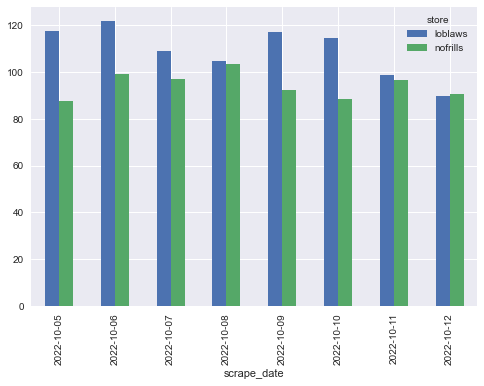

In [84]:
# Visualize the total cost of the shopping list each day of the week, and by store
ax = shop_list_daily_df.groupby(['store', 'scrape_date']).sum().unstack(0)['productPrice'].plot(kind='bar')

# remove the 00:00:00 from the date time in the x axis
ax.set_xticklabels(shop_list_daily_df.groupby(['store', 'scrape_date']).sum().unstack(0).index.format());

In [85]:
shop_list_daily_df.groupby('scrape_date')['productSKU'].count()

scrape_date
2022-10-05    60
2022-10-06    61
2022-10-07    58
2022-10-08    58
2022-10-09    60
2022-10-10    58
2022-10-11    58
2022-10-12    52
Name: productSKU, dtype: int64

In [86]:
shop_list_daily_df.groupby(['store', 'scrape_date']).sum()['productPrice'].unstack(0)['loblaws']

scrape_date
2022-10-05    117.64
2022-10-06    121.78
2022-10-07    109.21
2022-10-08    104.74
2022-10-09    117.39
2022-10-10    114.69
2022-10-11     98.91
2022-10-12     89.95
Name: loblaws, dtype: float64

In [87]:
shop_list_daily_df.groupby(['store','scrape_date'])['dealBadge'].count().unstack(0)['loblaws']

scrape_date
2022-10-05    16
2022-10-06    10
2022-10-07     9
2022-10-08     7
2022-10-09     9
2022-10-10     8
2022-10-11     9
2022-10-12     6
Name: loblaws, dtype: int64

In [88]:
from plotly.subplots import make_subplots

# Plotly visualize both store shopping list totals daily

# Create a subplot for a secondary axis to measure deal count
fig = make_subplots(specs=[[{'secondary_y': True}]])

fig.add_trace(go.Bar(
    x=shop_list_daily_df.groupby(['store', 'scrape_date']).sum()['productPrice'].unstack(0)['loblaws'].index,
    y=shop_list_daily_df.groupby(['store', 'scrape_date']).sum()['productPrice'].unstack(0)['loblaws'].values,
    name='Loblaws Bill',
    marker=dict(color='#e1251b')
))

fig.add_trace(go.Bar(
    x=shop_list_daily_df.groupby(['store', 'scrape_date']).sum()['productPrice'].unstack(0)['nofrills'].index,
    y=shop_list_daily_df.groupby(['store', 'scrape_date']).sum()['productPrice'].unstack(0)['nofrills'].values,
    name='NoFrills Bill',
    marker=dict(color='rgb(255, 215, 0)')
))


fig.add_trace(go.Scatter(x=shop_list_daily_df.groupby(['store','scrape_date'])['dealBadge'].count().unstack(0)['loblaws'].index, y=shop_list_daily_df.groupby(['store','scrape_date'])['dealBadge'].count().unstack(0)['loblaws'].values, line=dict(color='maroon'), name='Deal count Loblaws'), secondary_y=True)
fig.add_trace(go.Scatter(x=shop_list_daily_df.groupby(['store','scrape_date'])['dealBadge'].count().unstack(0)['nofrills'].index, y=shop_list_daily_df.groupby(['store','scrape_date'])['dealBadge'].count().unstack(0)['nofrills'].values, line=dict(color='yellow'), name='Deal count NoFrills'), secondary_y=True)


# Set y-axes titles
fig.update_yaxes(title_text="<b>Dollars (CAD)</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Deal Count</b>", secondary_y=True)

# Set title
fig.update_layout(title_text="Total bill and deal count for shopping list, daily")


py.iplot(fig)

I ran that shopping list against the dataframe. I wanted to see what my total bill was at each store every day, and how many items were on sale that day.


I noticed something interesting. The day we usually go shopping is Saturday. This is October 8th on the graph. That is the day the prices are highest at Nofrills, despite there being a spike of items that were on sale on my shopping list. This shows me that by shopping at nofrills on any other day of the week I will save more money.


That being said, I need more data to come to any real conclusion. This was the Thanksgiving weekend, and with any holiday, businesses can adjust their prices to take advantage of the holiday rush. So I will keep scraping every week to confirm that Saturday is actually the most expensive day of the week to shop at nofrills. And we will adjust the day we go shopping accordingly.


In [102]:
# Plotly version for interactive presentation
data = shop_list_daily_df.groupby('category')['productSKU'].count()
fig = go.Figure(data=[go.Pie(labels=data.index, values=data.values)])
fig.update_traces(textposition='inside', textinfo='percent+label', title_text="Shopping List Product Distribution")
fig.show()

In [89]:
# find shopping list items in the latest dataframe
shopping_list_latest_df = latest_df[pd.DataFrame(latest_df['productSKU'].tolist()).isin(shopping_list).any(1).values]

In [99]:
#shopping list at LOBLAWS
shopping_list_latest_df[shopping_list_latest_df['store'] == 'loblaws'].drop_duplicates(subset='productSKU')

,productSKU,productName,productBrand,productPrice,dealBadge,loyaltyBadge,textBadge,category,store,scrape_date
0,20070132001_EA,English Cucumber,NaN,1.69,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12
6,20600927001_EA,Carrots,Farmer's Market,1.29,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12
564,20959677_EA,Cooking Spinach,NaN,3.49,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12
567,20811362001_EA,Red Onions,Farmer's Market,4.99,sale,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12
578,20067389001_EA,"Romaine Heart, 3 Pack",NaN,6.49,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12
624,21027142001_EA,Ontario Greenhouse-Grown Strawberries,President's Choice,5.99,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12
1145,20814294001_EA,Grade A Large Eggs,Burnbrae Farms,6.89,NaN,False,NaN,Dairy-and-Eggs,loblaws,2022-10-12
1150,20774431_EA,Whipping Cream,Neilson,1.99,sale,False,NaN,Dairy-and-Eggs,loblaws,2022-10-12
2064,20123609_EA,Half and Half Cream,Neilson,1.99,sale,False,NaN,Dairy-and-Eggs,loblaws,2022-10-12
3329,20315613005_EA,Small Shells Pasta,No Name,2.49,NaN,False,NaN,Pantry,loblaws,2022-10-12


In [91]:
# get the total price at loblaws for the latest date
shopping_list_latest_df[shopping_list_latest_df['store'] == 'loblaws'].drop_duplicates(subset='productSKU')['productPrice'].sum()

86.46000000000001

In [97]:
#shopping list at NOFRILLS
shopping_list_latest_df[shopping_list_latest_df['store'] == 'nofrills'].drop_duplicates(subset='productSKU')

,productSKU,productName,productBrand,productPrice,dealBadge,loyaltyBadge,textBadge,category,store,scrape_date
725,20117550001_EA,Sweet Baby Peppers,Farmer's Market,3.99,NaN,False,NaN,Fruits-and-Vegetables,nofrills,2022-10-12
735,20067389001_EA,"Romaine Heart, 3 Pack",NaN,4.99,NaN,False,NaN,Fruits-and-Vegetables,nofrills,2022-10-12
744,20600927001_EA,Carrots,Farmer's Market,2.49,NaN,False,NaN,Fruits-and-Vegetables,nofrills,2022-10-12
825,20921434001_EA,Naturally Imperfect Mixed Sweet Peppers 2.5lb Bag,No Name,5.00,NaN,False,NaN,Fruits-and-Vegetables,nofrills,2022-10-12
883,21111368001_EA,"Bartlett Pear, 2 L",Farmer's Market,5.99,NaN,False,NaN,Fruits-and-Vegetables,nofrills,2022-10-12
895,20959677_EA,Cooking Spinach,NaN,1.99,NaN,False,NaN,Fruits-and-Vegetables,nofrills,2022-10-12
898,20811362001_EA,Red Onions,Farmer's Market,3.99,NaN,False,NaN,Fruits-and-Vegetables,nofrills,2022-10-12
1043,20645558_EA,Snap Peas,Manns,5.99,NaN,False,NaN,Fruits-and-Vegetables,nofrills,2022-10-12
2150,20123609_EA,Half and Half Cream,Neilson,1.99,sale,False,NaN,Dairy-and-Eggs,nofrills,2022-10-12
2159,20814294001_EA,Grade A Large Eggs,Burnbrae Farms,6.49,NaN,False,NaN,Dairy-and-Eggs,nofrills,2022-10-12


In [92]:
# get the total price at nofrills for the latest date
shopping_list_latest_df[shopping_list_latest_df['store'] == 'nofrills'].drop_duplicates(subset='productSKU')['productPrice'].sum()

88.85

In [93]:
# Picking out a specfic product to look at
shopping_list_latest_df[shopping_list_latest_df['productSKU'] == '21027142001_EA']

,productSKU,productName,productBrand,productPrice,dealBadge,loyaltyBadge,textBadge,category,store,scrape_date
624,21027142001_EA,Ontario Greenhouse-Grown Strawberries,President's Choice,5.99,NaN,False,NaN,Fruits-and-Vegetables,loblaws,2022-10-12


In [94]:
# check out the latest deal badge (sales, or multi) counts
shopping_list_latest_df.groupby('store')['dealBadge'].value_counts().unstack()

dealBadge,multi,sale
store,,
loblaws,3,3
nofrills,2,4


In [138]:
# look at the latest indiviual sale items
shopping_list_latest_df[shopping_list_latest_df['dealBadge'] == 'sale'].drop_duplicates().sort_values(by='productSKU')

,productSKU,productName,productBrand,productPrice,dealBadge,loyaltyBadge,textBadge,category,store,scrape_date
1695,20048223001_EA,"Real Whipped Cream, Regular",Gay Lea,3.99,sale,False,NaN,Dairy-and-Eggs,loblaws,2022-10-11
2288,20048223001_EA,"Real Whipped Cream, Regular",Gay Lea,1.99,sale,False,NaN,Dairy-and-Eggs,nofrills,2022-10-11
1165,20123609_EA,Half and Half Cream,Neilson,1.99,sale,False,NaN,Dairy-and-Eggs,loblaws,2022-10-11
2167,20123609_EA,Half and Half Cream,Neilson,1.99,sale,False,NaN,Dairy-and-Eggs,nofrills,2022-10-11
7904,20313447002_EA,Chick Peas,Unico,1.39,sale,True,NaN,Pantry,nofrills,2022-10-11
5126,20323113001_EA,"Oats, Quick",Quaker,4.99,sale,False,NaN,Pantry,loblaws,2022-10-11
1186,20774431_EA,Whipping Cream,Neilson,1.99,sale,False,NaN,Dairy-and-Eggs,loblaws,2022-10-11


In [95]:
# find shopping list items in the higher nofrills prices df
slst_nofrills_expensive_df = price_comp_nofrills[pd.DataFrame(price_comp_nofrills['productSKU'].tolist()).isin(shopping_list).any(1).values]
slst_nofrills_expensive_df
# These shopping list items are actually cheaper at Loblaws:

,productSKU,category,productName,productPrice_loblaws,productPrice_nofrills,dollar_diff,percent_diff
4,20600927001_EA,Fruits-and-Vegetables,Carrots,1.29,2.49,-1.2,63.492063
3815,20296100004_EA,Frozen,Ristorante Thin Crust Quattro Formaggi (4 Chee...,5.49,5.99,-0.5,8.710801


<a id='conclusion_id'></a>
## 5. Conclusion and Next Steps
From the analysis above, it is clear that there is a lot more variety at Loblaws when it comes to grocery products. However, you pay extra to shop for that variety. NoFrills is cheaper, but not always, for certain products.

The targeted analysis of my bill at both stores clearly shows that on a regular basis it is cheaper to shop at NoFrills for our staple foods.

### What is next?
Next, there are other parts of the websites that have matching categories; the home, beauty, and baby section for instance. There is also a marketplace that has cookware, small appliances, dining furniture, etc...

I would also like to automate this webscrape daily as a task that my computer automatically runs. Then add a feature that emails me a summary of my shopping list total for the latest date and which items are on sale.

The next challenge is to expand the product sections captured and include a variety of stores to compare the shopping list with. Maybe it is better to switch grocers if the price is consistently lower.